In [1]:
from lou_machine import update_data, import_data
from lou_machine import config
from lou_machine import stats
from lou_machine import model

import pandas as pd
import sqlite3

import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [12]:
# # Update lineups
update_data.update_lineups()
# # ud.update_mapping()
update_data.update_depthchart()

bullpen_dc = {"WHERE":{"pull_time":{"=":"(SELECT MAX(pull_time) FROM {table})".format(
              table=config.depthchart_table)}},"AND":{"position":{"=":"'BULLPEN'"}}}
abr = import_data.get_data(db=config.id_mapping_db, 
                    table=config.team_abr_table)                 # team abr table
lineups = import_data.get_data(db=config.players_db_path,
                        table=config.lineups_table,
                        condition_dict={"WHERE":{"pull_time":{"=":"(SELECT MAX(pull_time) FROM {table})".format(
              table=config.lineups_table)}}})              # lineup table
player_map = import_data.get_data(db=config.id_mapping_db,
                           table=config.player_map_table,
                           cols=import_data.player_id_cols)             # playerid table
lineups_plus = lineups.merge(player_map,left_on=['player_id'],
                             right_on=['rotowire_id'],how='left')
dc = import_data.get_data(db=config.players_db_path,
                   table=config.depthchart_table,
                   condition_dict=bullpen_dc)                    # Bullpen table
bp_ids = dc.merge(player_map,left_on=['player_id'],
                 right_on=['mlb_id'],how='left')

Daily Lineup Table Updated
Team Depth Charts updated


## Pull All Data Feeds
___
* Team Abrs
* Lineups
* Bullpen Depth Chart
* Player Mapping
* Event Data

In [13]:
event = import_data.get_data(db=config.mlb_db_path,
                     table=config.mlb_event_table,
                     condition_dict={'WHERE':import_data.current_year_condition['WHERE']}) # Event Data

## Set up Data Environment

In [14]:
calc = stats.baseball_stats.metric_calculator(data=event)

## Test Teams
___

In [15]:
bp_id_list = calc.calculate_v2(df=event,
                               groupby=['pitcher'], 
                               position='pitcher',
                               player_ids=list(bp_ids['retro_id'].dropna()),
                               metric='FIP_v2')

In [16]:
bp_fip = bp_ids[['team_name','retro_id']].groupby(['team_name']).apply(
    lambda x: calc.calculate(player_ids=x['retro_id'],metric='FIP'))
bp_whip = bp_ids[['team_name','retro_id']].groupby(['team_name']).apply(
    lambda x: calc.calculate(player_ids=x['retro_id'],metric='WHIP'))
bp_quant = ((bp_fip + bp_whip)*4)-30
bp_fip = bp_fip.fillna(bp_fip.mean())
all_pitchers = player_map[player_map['rotowire_pos'] == 'P']['retro_id'].dropna().tolist()
ap_fip = calc.calculate(player_ids=all_pitchers, metric='wRAA')

In [17]:
ap_fip = 0

In [18]:
def forecast_fixture(fixture):
    ### Sort teams and lineups
    fix_team = list(set(fixture['team']))
    team0 = fix_team[0]
    team1 = fix_team[1]
    team0_df = lineups_plus[lineups_plus['team'] == team0]
    team1_df = lineups_plus[lineups_plus['team'] == team1]
    team0_batters = team0_df[team0_df['position'] != 'P']['retro_id'].dropna().tolist()
    team1_batters = team1_df[team1_df['position'] != 'P']['retro_id'].dropna().tolist()
    team0_pitcher = team0_df[team0_df['position'] == 'P']['retro_id'].dropna().tolist()
    team1_pitcher = team1_df[team1_df['position'] == 'P']['retro_id'].dropna().tolist()
    ### Get pitching stats
    t0_sp_fip = calc.calculate(player_ids=team0_pitcher, metric='wRAA')
    team0_dc = abr.set_index('lineups')['depth_chart_mlb'][team0]
    team1_dc = abr.set_index('lineups')['depth_chart_mlb'][team1]
    t0_bp_fip = bp_quant[team0_dc]
    t1_sp_fip = calc.calculate(player_ids=team1_pitcher, metric='wRAA')
    t1_bp_fip = bp_quant[team1_dc]
    if np.isnan(t0_sp_fip):
        t0_sp_fip = ap_fip
    if np.isnan(t1_sp_fip):
        t1_sp_fip = ap_fip
    ### Get batting stats
    t0_wOBA = calc.calculate(player_ids=team0_batters, metric='wRAA')
    t1_wOBA = calc.calculate(player_ids=team1_batters, metric='wRAA')
    ### Forecast Score
    t1_score = (t1_wOBA + (t0_sp_fip*(5.5/9)+t0_bp_fip*(3.5/9))*2)/162
    t0_score = (t0_wOBA + (t1_sp_fip*(5.5/9)+t1_bp_fip*(3.5/9))*2)/162
    
    if t1_score < 0:
        if t0_score < 0:
            t1_score = abs(t1_score)
            t0_score = abs(t0_score)
        else:
            t0_score = t0_score - t1_score
            t1_score = 0
    else:
        pass
    if t0_score < 0:
        if t1_score < 0:
            t0_score = abs(t0_score)
            t1_score = abs(t1_score)
        else:
            t1_score = t1_score - t0_score
            t0_score = 0
    else:
        pass
            
    return team0, t0_score, team1, t1_score

In [19]:
print('------------------')
for fx in set(lineups_plus['fixture']):
    fixture = lineups_plus[lineups_plus['fixture']==fx]
    team0, t0_score, team1, t1_score = forecast_fixture(fixture)
    print('{},{},{},{}'.format(team0,round(t0_score,2),round(t1_score,2),team1))
print('------------------')

------------------
PHI,0.78,0,MIA
WAS,0.48,0.06,SD
TOR,0.09,0.55,OAK
TB,0.01,0.93,BOS
MIL,0.7,0.32,NYM
ATL,0.38,0.67,COL
DET,0.07,0.31,CWS
BAL,0,0.51,MIN
CLE,0.39,0.71,HOU
ANA,0.19,0,KC
STL,0.37,0.43,CIN
ARI,0,0.32,CHC
TEX,0,0.33,SEA
LAD,0.6,0.03,PIT
NYY,0.0,0.2,SF
------------------


In [20]:
lineups[['fixture','lineup_odds','team']].groupby(
    ['fixture','lineup_odds']).sum()[[]].reset_index()['lineup_odds'].to_clipboard(index=False)

In [21]:
lineups[['fixture','lineup_status','team']].groupby(
    ['fixture','team']).first()


lineup_status
fixture team              
1       MIA       Expected
        PHI       Expected
2       SD        Expected
        WAS       Expected
3       OAK       Expected
        TOR       Expected
4       BOS       Expected
        TB        Expected
5       MIL       Expected
        NYM       Expected
6       ATL       Expected
        COL       Expected
7       CWS       Expected
        DET       Expected
8       BAL       Expected
        MIN       Expected
9       CLE       Expected
        HOU       Expected
10      ANA       Expected
        KC        Expected
11      CIN       Expected
        STL       Expected
12      ARI       Expected
        CHC       Expected
13      SEA       Expected
        TEX       Expected
14      LAD       Expected
        PIT       Expected
15      NYY       Expected
        SF        Expected

In [77]:
print(' _______________________________')
for fx in set(lineups_plus['fixture']):
    fixture = lineups_plus[lineups_plus['fixture']==fx]
    team0, t0_score, team1, t1_score = forecast_fixture(fixture)
    print('|{}\t|{}\t|{}\t|{}\t|'.format(team0,round(t0_score*3,3),round(t1_score*3,3),team1))
print('|———————|———————|———————|———————|')

 _______________________________
|NYY	|5.829	|0	|BAL	|
|WAS	|3.683	|1.793	|NYM	|
|MIL	|4.176	|4.028	|STL	|
|ATL	|2.481	|3.873	|PHI	|
|TOR	|0.73	|0.611	|DET	|
|TB	|1.572	|5.477	|HOU	|
|CHC	|3.823	|0.79	|TEX	|
|OAK	|2.211	|2.25	|ANA	|
|CLE	|1.337	|2.486	|MIN	|
|PIT	|1.328	|3.035	|CIN	|
|SD	|1.503	|0.367	|SF	|
|MIA	|0	|4.994	|COL	|
|ARI	|1.372	|4.031	|LAD	|
|KC	|0	|0.962	|CWS	|
|BOS	|4.579	|2.386	|SEA	|
|———————|———————|———————|———————|


In [17]:
def forecast_fixture(fixture):
    ### Sort teams and lineups
    team0 = list(set(fixture['team']))[0]
    team1 = list(set(fixture['team']))[1]
    team0_df = lineups_plus[lineups_plus['team'] == team0]
    team1_df = lineups_plus[lineups_plus['team'] == team1]
    team0_batters = team0_df[team0_df['position'] != 'P']['retro_id'].dropna().tolist()
    team1_batters = team1_df[team1_df['position'] != 'P']['retro_id'].dropna().tolist()
    team0_pitcher = team0_df[team0_df['position'] == 'P']['retro_id'].dropna().tolist()
    team1_pitcher = team1_df[team1_df['position'] == 'P']['retro_id'].dropna().tolist()
    ### Get pitching stats
    t0_sp_fip = calc.calculate(player_ids=team0_pitcher, metric='FIP')
    team0_dc = abr.set_index('lineups')['depth_chart_mlb'][team0]
    team1_dc = abr.set_index('lineups')['depth_chart_mlb'][team1]
    t0_bp_fip = bp_fip[team0_dc]
    t1_sp_fip = calc.calculate(player_ids=team1_pitcher, metric='FIP')
    t1_bp_fip = bp_fip[team1_dc]
    if np.isnan(t0_sp_fip):
        t0_sp_fip = ap_fip
    if np.isnan(t1_sp_fip):
        t1_sp_fip = ap_fip
    ### Get batting stats
    t0_wOBA = calc.calculate(player_ids=team0_batters, metric='wOBA')
    t1_wOBA = calc.calculate(player_ids=team1_batters, metric='wOBA')
    ### Forecast Score
    t1_score = ((t0_sp_fip*(5.5/9)+t0_bp_fip*(3.5/9))*t1_wOBA)*2
    t0_score = ((t1_sp_fip*(5.5/9)+t1_bp_fip*(3.5/9))*t0_wOBA)*2
#     if type(t0_score) != float:
#         print(team0_batters)
#     if type(t1_score) != float:
#         print(team1_batters)
    return team0, t0_score, team1, t1_score

## Fantasy Scoring

In [29]:
athletics = list(set(lineups_plus[(lineups_plus['team'] =='OAK') & (lineups_plus['position'] != 'P')]['retro_id']))

In [30]:
stats = {}
for gameid in set(event[(event['gameid'].str.contains('OAK')) | (event['vteam'].str.contains('OAK'))]['gameid']):
    fs = lou_machine.model.baseball_stats.f_scoring(data=event[event['gameid']==gameid])
    stats.update({gameid:fs.get_batter_scoring(player_ids=athletics)})

In [37]:
def eventtype_counter(series,count_val):
    return (series==count_val).sum()

In [38]:
def baserunning_counter(df,runner_action): 
    ### Check out why dest can go up to 6 instead of just 0-4 
    """Tallys runs scored from each base and joins a frame of batters totals
    df is event dataframe and runner action is [score,steal]"""
    if runner_action=='score':
        cols = ['firstdest','seconddest','thirddest']
        check = 4
        fcol = 'Run Scored'
    elif runner_action=='steal':
        cols = ['sbfirst','sbsecond','sbthird']
        check = 'T'
        fcol = 'Stolen Base'
    h1 = df[df[cols[0]]==check][[cols[0],'firstrunner']].groupby('firstrunner').count()
    h2 = df[df[cols[1]]==check][[cols[1],'secondrunner']].groupby('secondrunner').count()
    h3 = df[df[cols[2]]==check][[cols[2],'thirdrunner']].groupby('thirdrunner').count()
    h_ = h1.join([h2,h3], how='outer')
    h = pd.DataFrame(h_.sum(axis=1))
    h.columns = [fcol]
    return h

In [39]:
season18 = event[event['gameid'].str.contains('2018')]

In [40]:
fs = pd.read_excel('/Users/ryand/git/lou-machine/data/fscoring.xlsx',
                   sheet_name='batter')[['FD']]
scoring = fs[fs['FD'abr] >0]

In [41]:
def get_batter_fscore(data,group,scoring,total=True):
    ### Get each scoring column
    sing = data.groupby(group).apply(
            lambda x: eventtype_counter(x[['eventtype']],count_val=20)
                                    ).rename(columns={'eventtype':'Single'})*scoring.loc['Single']['FD']
    doub = data.groupby(group).apply(
            lambda x: eventtype_counter(x[['eventtype']],count_val=21)
                                    ).rename(columns={'eventtype':'Double'})*scoring.loc['Double']['FD']
    trip = data.groupby(group).apply(
            lambda x: eventtype_counter(x[['eventtype']],count_val=22)
                                    ).rename(columns={'eventtype':'Triple'})*scoring.loc['Triple']['FD']
    homer = data.groupby(group).apply(
            lambda x: eventtype_counter(x[['eventtype']],count_val=23)
                                    ).rename(columns={'eventtype':'Home Runs'})*scoring.loc['Home Run']['FD']
    walk = data.groupby(group).apply(
            lambda x: eventtype_counter(x[['eventtype']],count_val=14)
                                    ).rename(columns={'eventtype':'Walk'})*scoring.loc['Walk']['FD']
    rbi = data[
        group + ['rbionplay']].groupby(group).sum().rename(columns={'rbionplay':'RBI'})*scoring.loc['RBI']['FD']
    rs = baserunning_counter(data, runner_action='score')*scoring.loc['Run Scored']['FD']
    sb = baserunning_counter(data, runner_action='steal')*scoring.loc['Stolen Base']['FD']
    ## Combine columns to single frame
    fs_tally = sing.join([doub,trip,homer,rbi,rs,sb,walk]).fillna(0)
    if total:
        return fs_tally.sum(axis=1)
    else:
        return fs_tally

In [42]:
s18_f = get_batter_fscore(
    data=season18,
    group=['batter'],
    scoring=scoring)

In [43]:
s18_fn =get_batter_fscore(
    data=season18,
    group=['batter'],
    scoring=scoring,
    total=False)

In [44]:
calc = lou_machine.model.baseball_stats.metric_calculator(data=season18)

In [45]:
player_woba = {}
for batter in set(season18['batter']):
    player_woba.update({batter:calc.calculate(player_ids=[batter], metric='wOBA')})

In [46]:
player_ba = {}
for batter in set(season18['batter']):
    player_ba.update({batter:calc.calculate(player_ids=[batter], metric='BA')})

In [47]:
player_slg = {}
for batter in set(season18['batter']):
    player_slg.update({batter:calc.calculate(player_ids=[batter], metric='SLG')})

In [48]:
player_wraa = {}
for batter in set(season18['batter']):
    player_wraa.update({batter:calc.calculate(player_ids=[batter], metric='wRAA')})

In [49]:
ab = season18[season18['abflag']=='T'][['batter','abflag']].groupby('batter').count()['abflag']

In [50]:
s18_fd = pd.DataFrame(s18_fn.as_matrix()/scoring.T.as_matrix())
s18_fd.columns = s18_fn.columns
s18_fd.index = s18_fn.index

In [51]:
X = pd.DataFrame()

X['wOBA'] = pd.Series(player_woba)
X['BA'] = pd.Series(player_ba)
X['SLG'] = pd.Series(player_slg)
X['wRAA'] = pd.Series(player_wraa)
X['AB'] = ab

X = X.fillna(0)

In [52]:
y=s18_f

In [53]:
learn_x = X[:700]
learn_y = y[:700]
test_x = X[700:]
test_y = y[700:]

OLS = linear_model.LinearRegression(fit_intercept=False)
OLS.fit(X=learn_x.as_matrix(),y=learn_y)
OLS.coef_

array([  67.97026784, -159.38984063,   57.38048866,    9.93198043,
          2.28173994])

In [56]:
X.columns

Index(['wOBA', 'BA', 'SLG', 'wRAA', 'AB'], dtype='object')

In [54]:
OLS.score(X=test_x.as_matrix(),y=test_y)

0.9948835157502888

In [57]:
season18['date'] = season18.gameid.apply(lambda x: x[3:12])

In [58]:
batter_date = season18.groupby(['date']).apply(lambda x: get_batter_fscore(data=x,
                                                             group=['batter'],
                                                             scoring=scoring,
                                                             total=True))

In [59]:
season18['hitflag'] = season18['hitvalue']/season18['hitvalue']

In [60]:
batter_date = season18[season18['abflag']=='T'].groupby(['batter','date']
                                                       ).agg({'hitvalue':'count',
                                                              'hitflag':'sum'})

In [61]:
batter_date_ = batter_date.unstack(level=0).fillna(0).cumsum().stack(level=1)

In [62]:
batter_date_['BA'] = batter_date_['hitflag']/batter_date_['hitvalue']

In [64]:
batter_date_['BA'].unstack(level=1)#.plot(figsize=(15,10),alpha=.1)

batter,abrej003,acunr001,adaml001,adamm002,adamw002,adduj002,adrie001,aguij001,ahmen001,albeh001,...,yatek001,yelic001,younc004,youne003,zagum002,zimmb001,zimmj003,zimmr001,zobrb001,zunim001
date,,,,,,,,,,,,,,,,,,,,,
201803290,0.400000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.333333,NaN,...,NaN,0.250000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
201803300,0.400000,NaN,0.500000,0.000000,NaN,NaN,NaN,1.000000,0.571429,NaN,...,NaN,0.222222,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.428571,NaN
201803310,0.250000,NaN,0.666667,0.200000,NaN,NaN,0.250000,0.500000,0.454545,NaN,...,NaN,0.500000,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.400000,NaN
201804010,0.250000,NaN,0.666667,0.200000,NaN,NaN,0.250000,0.500000,0.454545,NaN,...,NaN,0.500000,0.000000,NaN,NaN,0.111111,NaN,0.125000,0.363636,NaN
201804011,0.250000,NaN,0.666667,0.200000,NaN,NaN,0.250000,0.500000,0.454545,NaN,...,NaN,0.500000,0.000000,NaN,NaN,0.111111,NaN,0.125000,0.363636,NaN
201804012,0.250000,NaN,0.666667,0.200000,NaN,NaN,0.250000,0.500000,0.454545,NaN,...,NaN,0.500000,0.000000,NaN,NaN,0.111111,NaN,0.125000,0.363636,NaN
201804020,0.416667,NaN,0.500000,0.200000,NaN,NaN,0.200000,0.333333,0.470588,NaN,...,NaN,0.388889,0.000000,NaN,NaN,0.153846,NaN,0.083333,0.363636,NaN
201804030,0.437500,NaN,0.600000,0.200000,NaN,NaN,0.200000,0.333333,0.470588,NaN,...,NaN,0.434783,0.000000,NaN,NaN,0.125000,NaN,0.176471,0.363636,NaN
201804040,0.400000,NaN,0.600000,0.222222,NaN,NaN,0.200000,0.250000,0.470588,NaN,...,NaN,0.384615,0.000000,NaN,NaN,0.142857,NaN,0.166667,0.363636,NaN


In [26]:
population = 7000000000
for x in range(63):
    population = round(population/2,0)
population

0.0

# Check salary pull

In [1]:
from lou_machine.data_ops.scraping import retrieve_past_salaries

In [14]:
import requests
from lxml import html, etree

def retrieve_past_salaries(years=None, weeks=None, site='fd'):
    """
    years: `list` {varies by site} Years to retrieve data from
    weeks: `list` {1 to 17}        To retrieve data from
    site:  `str`  {'fd', 'dk'}     Site to use as basis for scoring 
    Submit lists of years & weeks to retrieve previous data for. You can set the site ['fd', 'dk']
    for data to return from.

    Submitting None for either years or weeks will pull all available data. 
    This should be done sparingly as it can incurrs significant load on the site (ie. one
    time to backfill a database and then selectively update for previous week)
    """
    if years == None:
        years = range(2011,2019)
    if weeks == None:
        weeks = range(1,18)

    base_url = 'http://rotoguru1.com/cgi-bin/fyday.pl?week={week}&year={year}&game={site}&scsv=1'

    for year in years:
        for week in weeks:
            try:
                page = requests.get(base_url.format(week=week, year=year, site=site))
                tree = html.fromstring(page.content)
                csv = tree.xpath("//pre/text()")
                try:
                    len(final_csv)
                    final_csv += csv
                except:
                    final_csv = csv
            except:
                print("error pulling salaries for week {week}-{year} for {site}".format(week=week, year=year, site=site))
    return final_csv

In [17]:
sal_data = retrieve_past_salaries()

In [18]:
final_csv = [sal_data[0]] + ['\n'.join(line.split('\n')[1:]) for line in sal_data[1:]]

In [ ]:
with open('old_salaries.csv','w') as f:
    for week_data in final_csv:
        f.write(week_data)
    f.close()

# Look at Data

In [1]:
import pandas as pd

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('old_salaries.csv', sep=';')

In [33]:
df['season_week'] = df['Year'] - df['Year'].min() + df['Week']/df['Week'].max()

In [35]:
df.columns

Index(['Week', 'Year', 'GID', 'Name', 'Pos', 'Team', 'h/a', 'Oppt',
       'FD points', 'FD salary', 'season_week'],
      dtype='object')

In [46]:
df_ = pd.DataFrame()
for player in list(set(df['Name'])):
    player_set = df[df['Name'] == player]
    player_set['running_mean'] = player_set['FD points'].cumsum()/(range(1,len(player_set)+1))
    player_set['running_mean (known)'] = player_set['running_mean'].shift(1)
    df_ = df_.append(player_set)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [62]:
df_.to_csv('full_old_NFL.csv')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


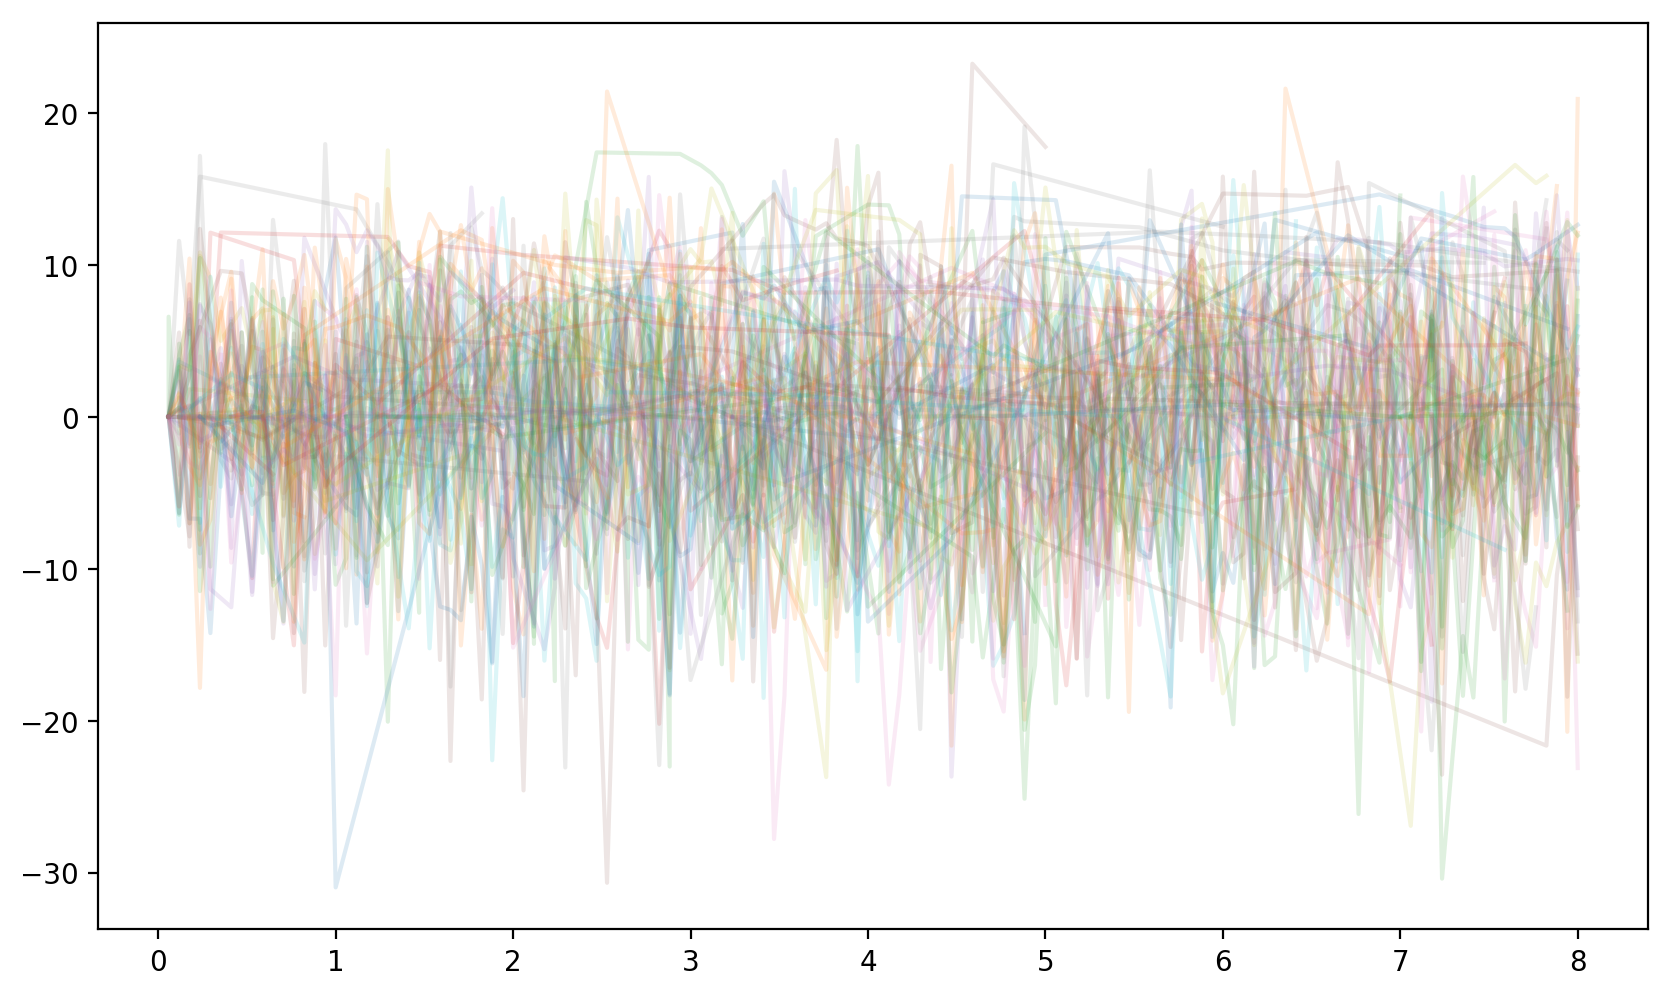

In [38]:
# fig, ax1 = plt.subplots(1,1, figsize=(10,6), dpi=200)

for player in list(set(df[df['Pos'] =='QB']['Name'])):
    player_set = df[df['Name'] == player]
    player_set['running_mean'] = player_set['FD points'].cumsum()/(range(1,len(player_set)+1))
    
#     ax1.plot(player_set['season_week'], 
#              player_set['running_mean']-player_set['FD points'],
# #              player_set['FD points'].cumsum()/(range(1,len(player_set)+1)), 
#              alpha=.15)

In [63]:
gg = pd.read_csv('old_NFL_with_count.csv')

In [67]:
gg_ = gg.groupby(['Name','Pos']).agg({'FD salary':'mean','count':'sum','FD points':'sum'})#.plot(kind='scatter',x='FD salary',y='count', figsize=(10,6))

In [69]:
gg_['per_count'] = gg_['count']/gg_['FD points']

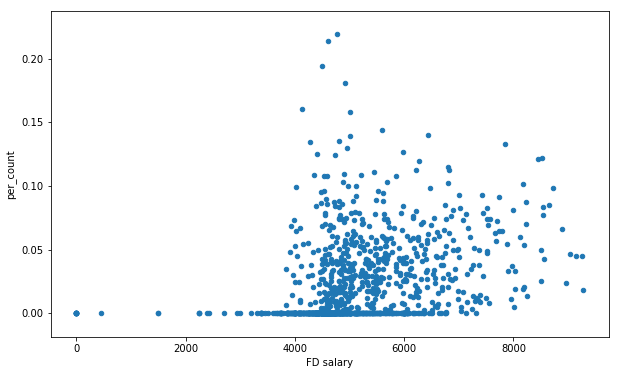

In [71]:
gg_[gg_['per_count'] < .5].plot(kind='scatter',
                                x='FD salary',
                                y='per_count',
                                figsize=(10,6))